# Dimensionality reduction on input data

# Dimensionality reduction

In [29]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from dynamax.hidden_markov_model import GaussianHMM

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
#from fitting_functions import cross_validate_model
#from plotting_functions import plot_transition_mat, plot_states_aligned, params_to_df, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, traces_over_sates

one = ONE()


### Get design matrices

In [5]:
bin_size = 0.1
var_names = ['avg_wheel_vel', 'pupil_diameter',
       'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
       'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
       'pupil_speed_Y', 'Gaussian_licks']

data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + str(bin_size) + '/'
os.chdir(data_path)
design_matrices = os.listdir(data_path)

In [1]:
design_matrices

NameError: name 'design_matrices' is not defined

## Preprocess list of design matrices

In [6]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
session_all = defaultdict(list)

for m, mat in enumerate(design_matrices):
   
    # Trials data
    session = design_matrices[m][14:-4]
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
    training_set = np.array(design_matrix[var_names]).copy() 
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # Normalize between 0 and 1
      normalizer = Normalizer().fit(standardized)
      normalized = normalizer.transform(standardized)
      
      # Save results
      matrix_all[mat].append(normalized)
      session_all[mat].append(session_trials)    

## PCA

In [39]:
"""
PRINCIPLE COMPONENT ANALYSES
"""

X = normalized # (n_samples, n_features)

# Mean centered and equal variance (redundant code)
#scaler = StandardScaler()
#scaler.fit(X)

pca = PCA() # svd_solver='full'
#pca.fit(scaler.transform(X))
X_reduced = pca.fit_transform(scaler.transform(X))


In [40]:
# Plot projections of datapoints into first 3 principal components
augmented_data = pd.DataFrame(columns=['bin'], index=range(len(X_reduced)))
augmented_data['bin'] = range(len(X_reduced))
augmented_data['pc1'] = X_reduced[:, 0].transpose()
augmented_data['pc2'] = X_reduced[:, 1].transpose()
augmented_data['pc3'] = X_reduced[:, 2].transpose()
augmented_data['pc4'] = X_reduced[:, 3].transpose()
augmented_data['pc5'] = X_reduced[:, 4].transpose()
augmented_data['pc6'] = X_reduced[:, 5].transpose()
augmented_data['pc7'] = X_reduced[:, 6].transpose()
augmented_data['pc8'] = X_reduced[:, 7].transpose()
augmented_data['pc9'] = X_reduced[:, 8].transpose()
augmented_data['pc10'] = X_reduced[:, 9].transpose()

Text(0, 0.5, '% Variance explained')

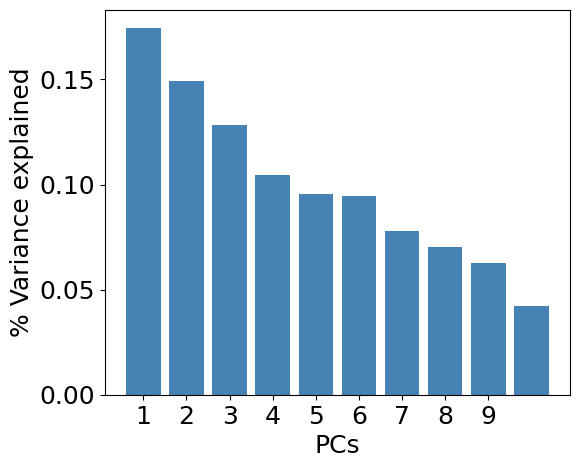

In [41]:
# Plot variance explained per principle component
fig, ax = plt.subplots(figsize=[6,5])
plt.rc('font', size=18)
keep_pc = np.shape(X)[1]
plt.bar(np.arange(1, keep_pc+1, 1), pca.explained_variance_ratio_[0:keep_pc], color='steelblue')
plt.xticks(np.arange(1, keep_pc, 1))
#plt.xlim([0, 3])
plt.xlabel('PCs')
plt.ylabel('% Variance explained')

<AxesSubplot: xlabel='pc1', ylabel='pc2'>

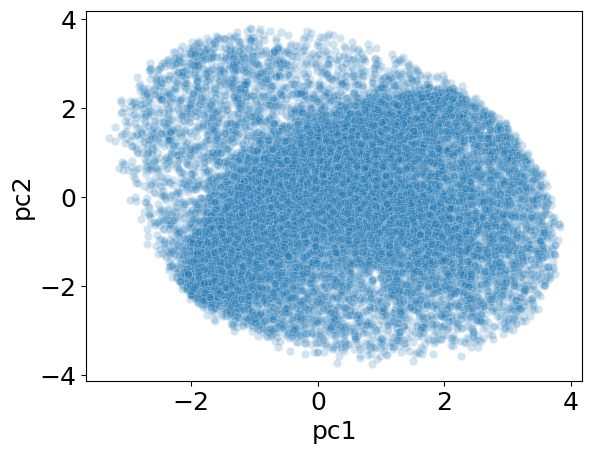

In [54]:
sns.scatterplot(x='pc1', y='pc2', data=augmented_data, alpha=0.2)

In [43]:
augmented_data
var_names = ['avg_wheel_vel', 'pupil_diameter',
    'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
    'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
    'pupil_speed_Y', 'Gaussian_licks']

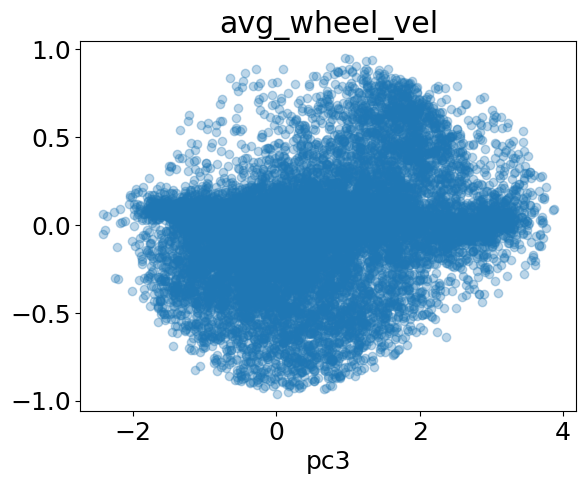

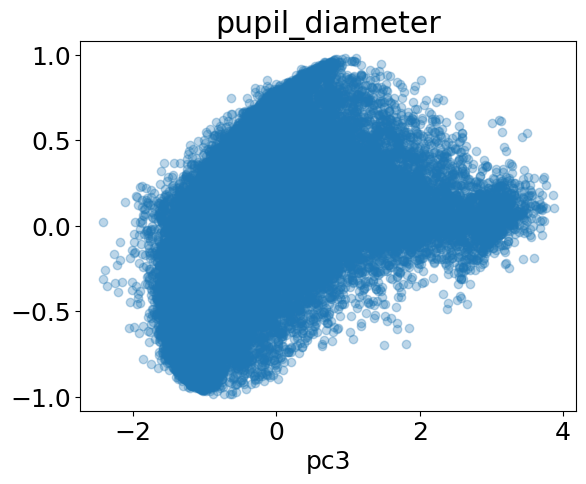

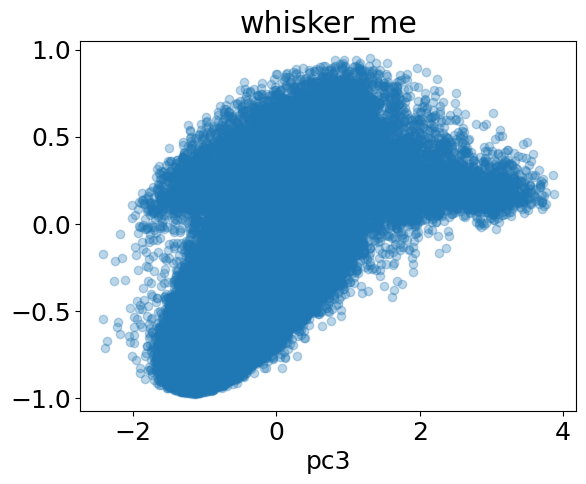

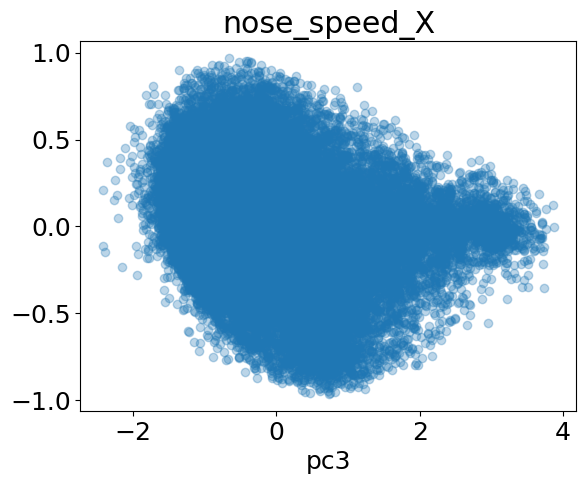

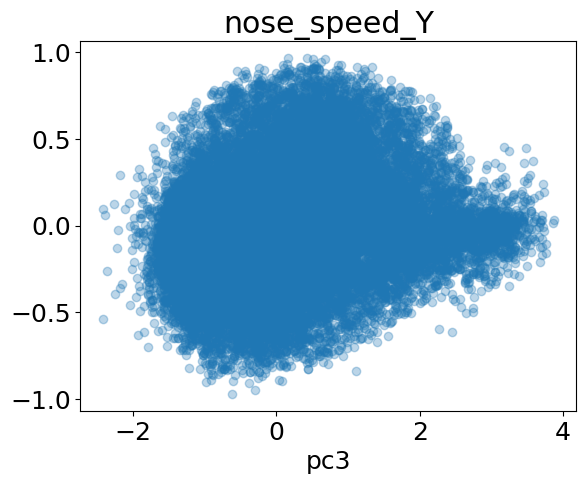

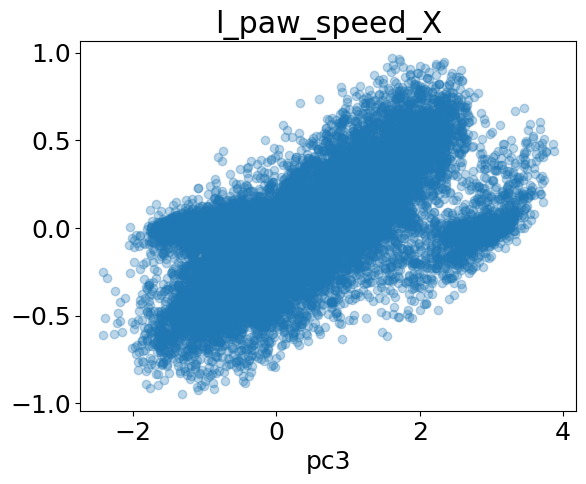

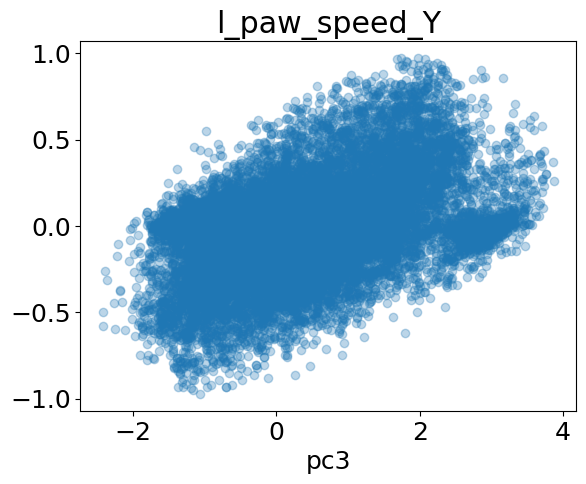

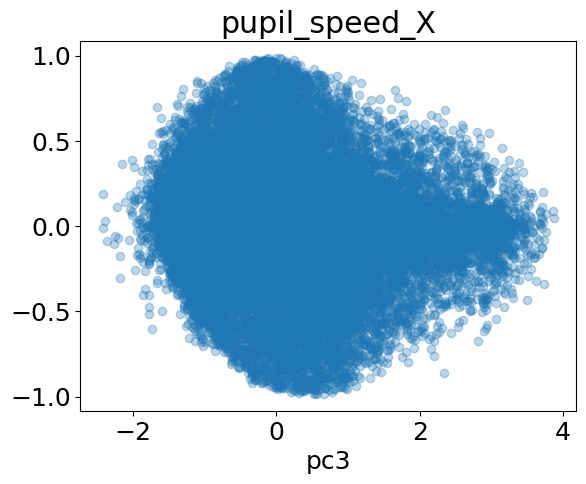

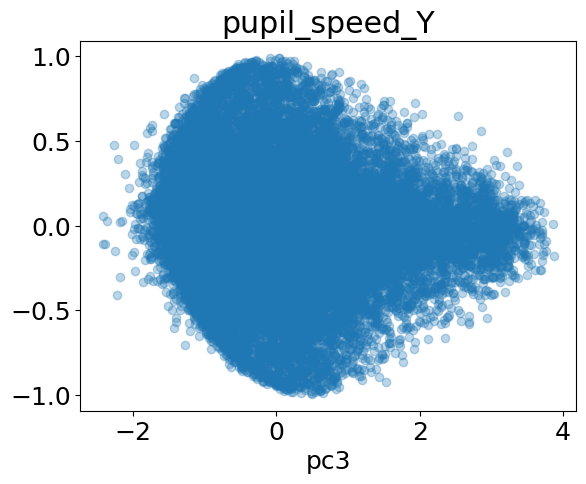

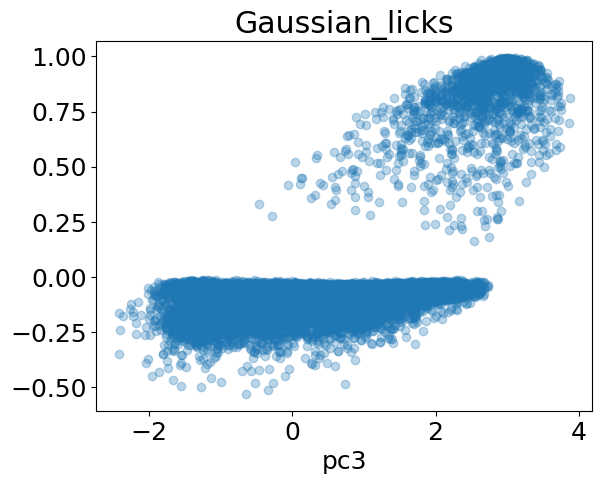

In [51]:
pc = 'pc3'
for v, var in enumerate(var_names):
    plt.scatter(np.array(augmented_data[pc]), X[:, v], alpha=0.3)
    plt.xlabel(pc)
    plt.title(var)
    plt.show()

## Overlay trial trajectories

## K-means clustering

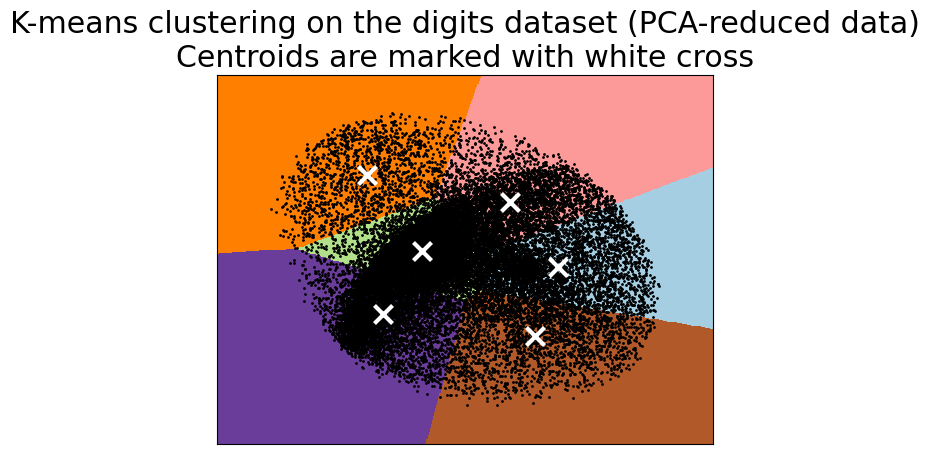

In [48]:
cluster_num = 6

kmeans = KMeans(init="k-means++", n_clusters=cluster_num, n_init=4)
kmeans.fit(X_reduced[:, 0:2])

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(X_reduced[:, 0], X_reduced[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()